Correlogram on basleine v1 raw data

# Notebook Setup

In [1]:
if 'google.colab' in str(get_ipython()):
  IN_COLLAB = True
else:
  IN_COLLAB = False

#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
if IN_COLLAB:
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Modules

In [2]:
# install required modules quietly
required_packages = ['geopandas', 'pyspark', 'azure-storage-blob']

for p in required_packages: 
  try:
      __import__(p)
  except ImportError:
      %pip install {p} --quiet

In [12]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import math
import json

import numpy as np
import pandas as pd
from calendar import monthrange
from datetime import datetime
from io import BytesIO

import seaborn as sns
import matplotlib.pyplot as plt

# Load locale custome modules
import sys
if IN_COLLAB:
  os.chdir(MY_HOME_ABS_PATH)
  sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
  sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

In [5]:
# File
container = "baseline-data"
ext = "parquet"
ver = "1"
blob_name_base = f"baseline_all_v_{ver}"
train_blob_name_base = f"baseline-train-v-{ver}"
test_blob_name_base = f"baseline-test-v-{ver}"

tag = "raw"
blob_name = f"{blob_name_base}_{tag}.{ext}"

# Read Raw File

In [6]:
data_df = None
raw_data_file_path = tmp_dir + os.sep + blob_name
print(f"loading {raw_data_file_path}...")
if not (os.path.exists(raw_data_file_path)):
    if not (os.path.exists(tmp_dir)):
        os.mkdir(tmp_dir)
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
    data_df = pd.read_parquet(file_stream, engine='pyarrow')
    data_df.to_parquet(raw_data_file_path)
else:
  data_df = pd.read_parquet(raw_data_file_path, engine='pyarrow') 

loading /content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling/.tmp/baseline_all_v_1_raw.parquet...


In [7]:
data_df.columns

Index(['GPP_NT_VUT_REF', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA',
       'P_ERA', 'PA_ERA', 'datetime', 'year', 'month', 'day', 'hour', 'date',
       'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'IGBP',
       'koppen', 'minute', 'site_id', 'elevation', 'lat', 'long', 'koppen_sub',
       'c3c4', 'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN',
       'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI',
       'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'MODIS_PFT'],
      dtype='object')

In [8]:
# sample points
sample_df = data_df.sample(500)

# Daily Data Analysis

## ERA Values
```
'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA'
```

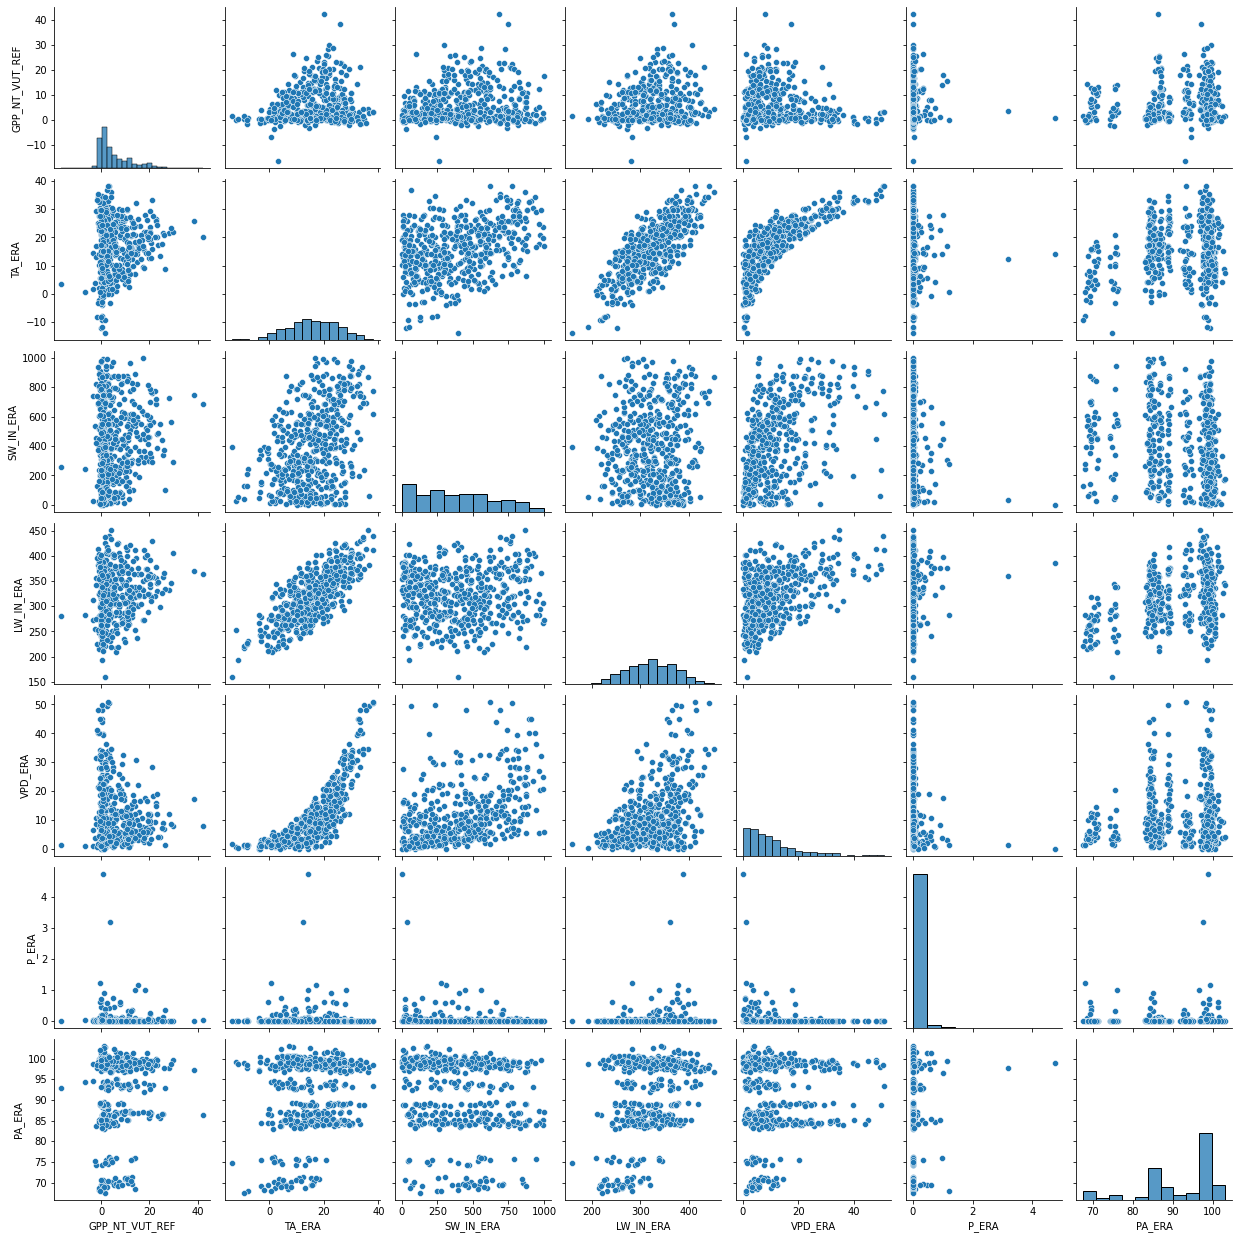

In [33]:
# Basic correlogram
cols = ['GPP_NT_VUT_REF', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA',
       'P_ERA', 'PA_ERA']
sns.pairplot(sample_df[cols])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


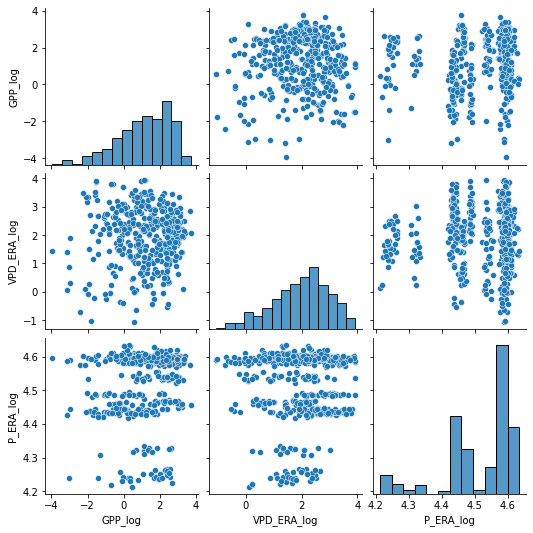

In [43]:
cols = ['GPP_log', 'VPD_ERA_log', 'P_ERA_log']
sample_df['GPP_log'] = np.log(sample_df['GPP_NT_VUT_REF'])  # has neg values
sample_df['VPD_ERA_log'] = np.log(sample_df['VPD_ERA'])     # has 0's 
sample_df['P_ERA_log'] = np.log(sample_df['PA_ERA'])
sns.pairplot(sample_df[cols])

## Vegetation Index
```
'EVI', 'NDVI', 'NIRv'
```

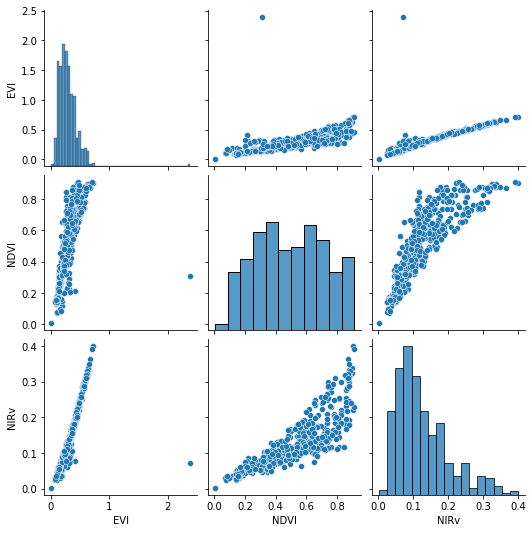

In [44]:
cols = ['EVI', 'NDVI', 'NIRv']
sns.pairplot(sample_df[cols])

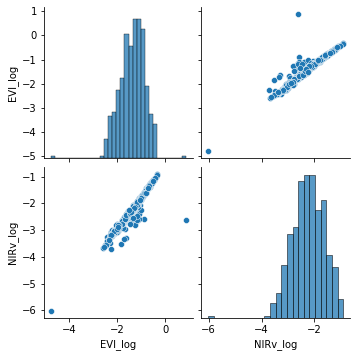

In [45]:
cols = ['EVI_log','NIRv_log']
sample_df['EVI_log'] = np.log(sample_df['EVI'])
sample_df['NIRv_log'] = np.log(sample_df['NIRv'])
sns.pairplot(sample_df[cols])

# Monthly Data

## BESS Values
```
'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN'
```

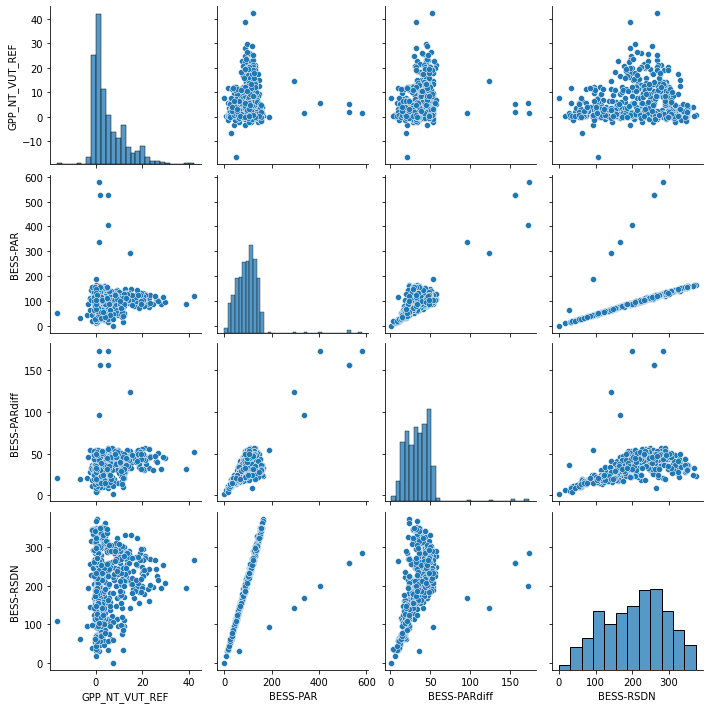

In [22]:
cols = ['GPP_NT_VUT_REF', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN']
sns.pairplot(sample_df[cols])

## Remote Sensing and Temperatures 
```
'CSIF-SIFdaily', 'Lai', 'Fpar', 'LST_Day', 'LST_Night', 'Ts'
```

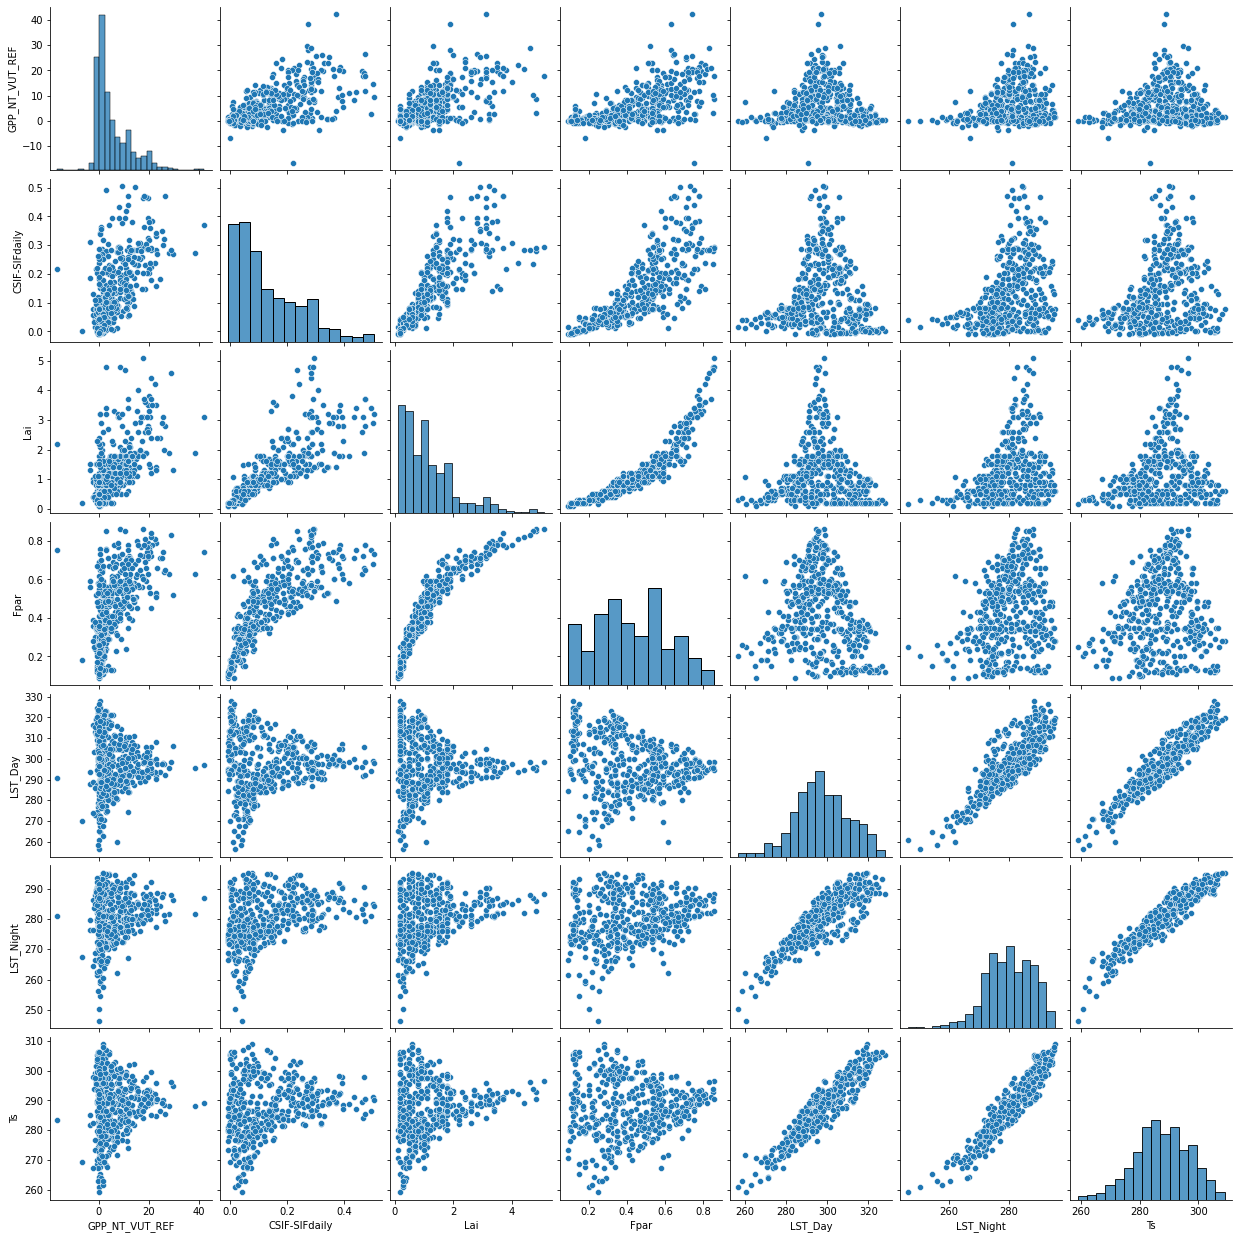

In [25]:
cols = ['GPP_NT_VUT_REF', 'CSIF-SIFdaily', 'Lai', 'Fpar', 'LST_Day', 'LST_Night', 'Ts']
sns.pairplot(sample_df[cols])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


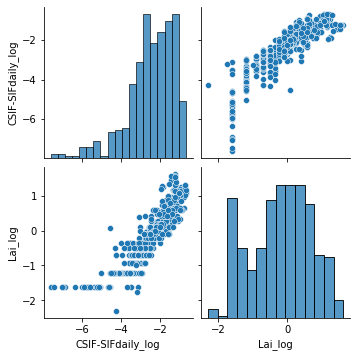

In [49]:
cols = ['CSIF-SIFdaily_log', 'Lai_log']
sample_df['Lai_log'] = np.log(sample_df['Lai']) # more nmal
sample_df['CSIF-SIFdaily_log'] = np.log(sample_df['CSIF-SIFdaily']) # becomes left-scewed instead, has neg values
sns.pairplot(sample_df[cols])

## Water-Related
```
'PET',  'ESACCI-sm', 'NDWI', 'Percent_Snow'
```

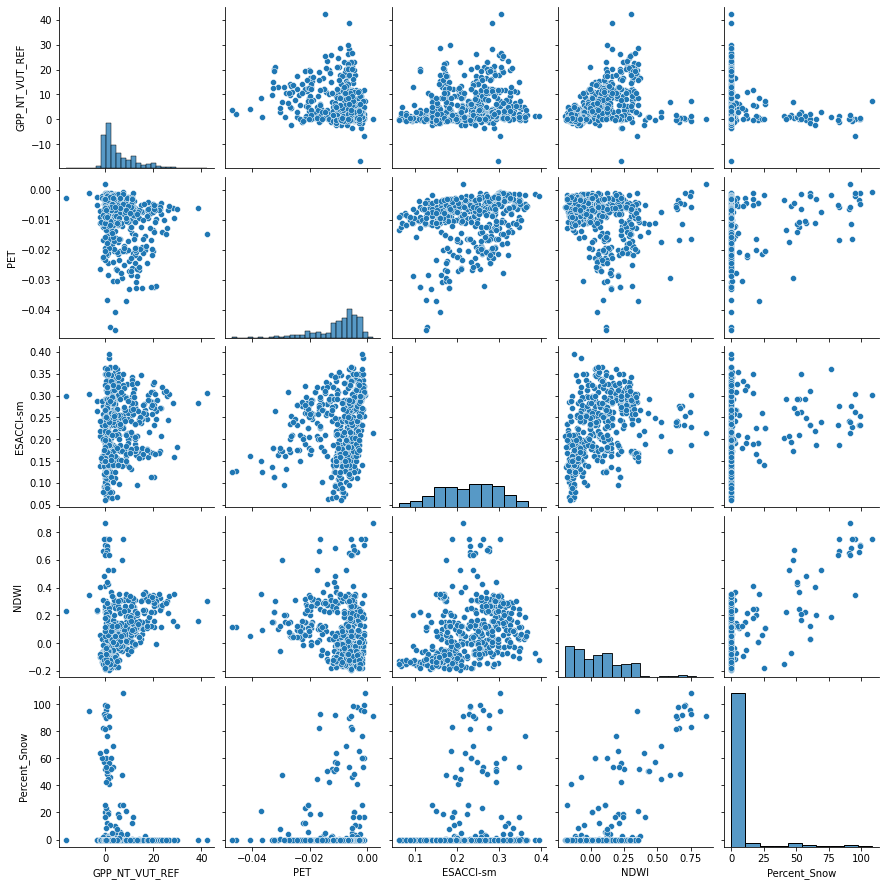

In [27]:
cols = ['GPP_NT_VUT_REF', 'PET',  'ESACCI-sm', 'NDWI', 'Percent_Snow']
sns.pairplot(sample_df[cols])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


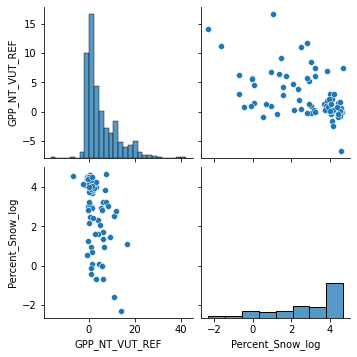

In [32]:
cols = ['GPP_NT_VUT_REF', 'Percent_Snow_log']
sample_df['Percent_Snow_log'] = np.log(sample_df['Percent_Snow']) #??
sns.pairplot(sample_df[cols])